In [150]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from random import seed,sample
import datetime as dt
from datetime import datetime
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler # Undersampling for Unbalanced Data
from imblearn.over_sampling import SMOTE # Oversampling for Unbalanced Data
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Data Encoders
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


pd.set_option('display.max_columns', 500)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [151]:
X_train = pd.read_csv('../X_train.csv')
X_val = pd.read_csv('../X_val.csv')
y_train = pd.read_csv('../y_train.csv')
y_val = pd.read_csv('../y_val.csv')

# test set only for one-time assessment of final model
X_test = pd.read_csv('../X_test.csv')
y_test = pd.read_csv('../y_test.csv')

Scale the features below only, we don't scale the hour_of_day since the values are already within a similar range and have a clear numerical interpretation (hours of the day)

In [152]:
from sklearn.preprocessing import StandardScaler

features_to_scale = ['hour_of_day', 'distance', 'amount(usd)']

# Initialize the StandardScaler and fit/transform on numerical features
scaler = StandardScaler()

# Fit and transform the scaler on the selected features in your training data
X_train_scaled = X_train.copy()
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# Transform the same selected features in validation data using the same scaler
X_val_scaled = X_val.copy()
X_val_scaled[features_to_scale] = scaler.transform(X_val[features_to_scale])

# Transform the same selected features in test data using the same scaler
X_test_scaled = X_test.copy()
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

In [153]:
X_test_scaled.head()

,hour_of_day,day_of_week,category,gender,age_group,state,job_category,distance,amount(usd)
0,-0.705493,Tuesday,shopping_pos,F,61-80,NY,C2,-0.701223,-0.437322
1,0.761922,Tuesday,shopping_pos,F,21-40,MO,C3,1.941211,-0.436237
2,0.174956,Friday,food_dining,F,21-40,TX,C2,1.709572,-0.394625
3,0.174956,Tuesday,shopping_pos,M,21-40,MS,C3,-0.041440,-0.383903
4,-0.412010,Tuesday,entertainment,M,61-80,CA,C1,0.545014,-0.433110


We will then be one hot encoding some of our categorical variables to run a logistic regression model on X and y.

In [155]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder with sparse=False and drop='first'
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform the encoder on categorical columns in the training data
X_train_encoded = encoder.fit_transform(X_train_scaled[['day_of_week', 'category', 'gender','age_group', 'state', 'job_category']])


# Transform the same columns in the validation data
X_val_encoded = encoder.transform(X_val_scaled[['day_of_week', 'category', 'gender','age_group', 'state', 'job_category']])

# Transform the same columns in the test data
X_test_encoded = encoder.transform(X_test_scaled[['day_of_week', 'category', 'gender','age_group', 'state', 'job_category']])

# Create DataFrames from the encoded arrays with appropriate column names
encoded_columns = encoder.get_feature_names_out(['day_of_week', 'category', 'gender','age_group', 'state', 'job_category'])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns)
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_columns)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_columns)

In [156]:
X_train_final = pd.concat([X_train_encoded_df.reset_index(drop=True), X_train_scaled[['hour_of_day', 'distance', 'amount(usd)']].reset_index(drop=True)], axis=1)
X_val_final = pd.concat([X_val_encoded_df.reset_index(drop=True), X_val_scaled[['hour_of_day', 'distance', 'amount(usd)']].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded_df.reset_index(drop=True), X_test_scaled[['hour_of_day', 'distance', 'amount(usd)']].reset_index(drop=True)], axis=1)



In [157]:
# Print the shapes of X_train, X_test, y_train, y_test
print("X_train_final shape:", X_train_final.shape)
print("X_val_final shape:", X_val_final.shape)
print("X_test_final shape:", X_test_final.shape)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train_final shape: (1481915, 85)
X_val_final shape: (185239, 85)
X_test_final shape: (185240, 85)
y_train shape: (1481915, 1)
y_val shape: (185239, 1)
y_test shape: (185240, 1)


In [158]:
X_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185240 entries, 0 to 185239
Data columns (total 85 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   day_of_week_Monday       185240 non-null  float64
 1   day_of_week_Saturday     185240 non-null  float64
 2   day_of_week_Sunday       185240 non-null  float64
 3   day_of_week_Thursday     185240 non-null  float64
 4   day_of_week_Tuesday      185240 non-null  float64
 5   day_of_week_Wednesday    185240 non-null  float64
 6   category_food_dining     185240 non-null  float64
 7   category_gas_transport   185240 non-null  float64
 8   category_grocery_net     185240 non-null  float64
 9   category_grocery_pos     185240 non-null  float64
 10  category_health_fitness  185240 non-null  float64
 11  category_home            185240 non-null  float64
 12  category_kids_pets       185240 non-null  float64
 13  category_misc_net        185240 non-null  float64
 14  cate

## Random Forest (Baseline Model)

In [159]:
#We are going to ensure that we have the same splits of the data every time. 
#We can ensure this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5.

kf = StratifiedKFold(n_splits=5, shuffle=False)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)



In [13]:
score = cross_val_score(rf_classifier, X_train_final, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.65136936 0.6565507  0.62250185 0.66913397 0.63091716]
Average Cross Validation Recall score: 0.6460946088586583


model correctly identifies about 64.61% of the actual positive instances in the training data across different folds.

In [160]:
from sklearn.impute import SimpleImputer

# Initialize the imputer with the median strategy
imputer = SimpleImputer(strategy='median')

# Fit and transform on X_train_final
X_train_final = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)

# Transform X_val_final using the same imputer
X_val_final = pd.DataFrame(imputer.transform(X_val_final), columns=X_val_final.columns)

# Transform X_test_final using the same imputer
X_test_final = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

In [162]:
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train_final, y_train)

RandomForestClassifier(random_state=42)

In [163]:
y_val_pred = baseline_rf.predict(X_val_final)

In [164]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
cm = confusion_matrix(y_val, y_val_pred)

base_precision = precision_score(y_val, y_val_pred)
base_recall = recall_score(y_val, y_val_pred)
base_f1 = f1_score(y_val, y_val_pred)
base_roc_auc = roc_auc_score(y_val, y_val_pred)
base_pr_auc = average_precision_score(y_val, y_val_pred)

print(cm)

[[184248     26]
 [   283    682]]


In [165]:
ndf = [(base_recall, base_precision, base_f1, base_pr_auc, base_roc_auc)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'PR AUC', 'ROC_AUC'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,No Under/Oversampling,0.706736,0.963277,0.815302,0.68231,0.853297


The recall of 70.67% indicates that the model correctly identified about 70.67% of the actual positive cases (frauds). This metric is crucial in fraud detection to capture a substantial portion of fraudulent transactions.

The precision of 96.33% shows that out of all the predicted positive cases, approximately 96.33% were true positives. A higher precision is beneficial for reducing false positives and avoiding unnecessary interventions.

The F1 Score, at 81.53%, represents the harmonic mean of precision and recall. This balanced metric indicates a strong compromise between precision and recall, demonstrating the model's effectiveness in identifying both true positives and minimizing false positives.

The PR AUC, with a value of 68.23%, measures the area under the precision-recall curve. This metric evaluates the trade-off between precision and recall, with a higher PR AUC being desirable.

The ROC AUC of 85.33% measures the area under the ROC curve, reflecting the model's performance across different thresholds. A higher ROC AUC indicates good discrimination between classes, demonstrating the model's ability to distinguish between positive and negative instances.

## Random Forest with Random Over Sampler

In [166]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
ros = RandomOverSampler(random_state=42)

In [167]:
# fit and apply the transform
X_over, y_over = ros.fit_resample(X_train_final, y_train)

Training Model

In [168]:
from imblearn.pipeline import Pipeline, make_pipeline

random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))
#cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [21]:
score2 = cross_val_score(random_overs_pipeline, X_train_final, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

Cross Validation Recall Scores are: [0.68911917 0.70392302 0.67283494 0.70836417 0.67011834]
Average Cross Validation Recall score: 0.6888719291867956


 model correctly identifies about 68.89% of the actual positive instances in the training data across different folds.

In [169]:
print('Genuine:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

Genuine: 1474194 / 50.0 % of the dataset
Frauds: 1474194 / 50.0 % of the dataset


In [170]:
random_overs_pipeline.fit(X_over, y_over)

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=13))])

In [171]:
y_val_pred_oversampled = random_overs_pipeline.predict(X_val_final)

In [214]:
random_forest_classifier = random_overs_pipeline.named_steps['randomforestclassifier']

print("Random Forest Classifier Parameters:")
print(random_forest_classifier.get_params())

Random Forest Classifier Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 13, 'verbose': 0, 'warm_start': False}


In [172]:
cm = confusion_matrix(y_val, y_val_pred_oversampled)

over_rf_Recall = recall_score(y_val, y_val_pred_oversampled)
over_rf_Precision = precision_score(y_val, y_val_pred_oversampled)
over_rf_f1 = f1_score(y_val, y_val_pred_oversampled)
over_rf_accuracy = accuracy_score(y_val, y_val_pred_oversampled)
over_roc = roc_auc_score(y_val, y_val_pred_oversampled)
over_prauc = average_precision_score(y_val, y_val_pred_oversampled)

print(cm)

[[184225     49]
 [   236    729]]


In [173]:
ndf = [(over_rf_Recall, over_rf_Precision, over_rf_f1, over_prauc, over_roc)]

over_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'PR AUC', 'ROC_AUC'])
over_rf_score.insert(0, 'Random Forest with', 'Random Oversampling')
over_rf_score

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,Random Oversampling,0.75544,0.937018,0.836489,0.709135,0.877587


Recall: The model achieved a recall of 75.54%, indicating its ability to effectively identify about 75.54% of actual positive cases (frauds). This suggests an improvement compared to the baseline model.

Precision: With a precision of 93.70%, the model demonstrates high accuracy in identifying true positive cases while minimizing false positives. This precision level is notably strong.

F1 Score: The F1 Score, at 83.65%, signifies a balanced performance, effectively compromising between precision and recall. This indicates the model's ability to maintain a robust balance in fraud detection.

PR AUC: The Precision-Recall AUC of 70.91% showcases the model's ability to balance precision and recall, especially in capturing positive instances. This is an improvement compared to the baseline.

ROC AUC: The ROC AUC of 87.76% demonstrates the model's accuracy in distinguishing between positive and negative instances, reflecting robust discrimination. This is an improvement compared to the baseline.

**GridSearch for Oversampling, tuning of hyperparameters**

In [191]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [6, 10, 12],
    'random_state': [13]
}

In [192]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_over_rf = GridSearchCV(random_overs_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
grid_over_rf.fit(X_train_final, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='f1')

In [ ]:
# from imblearn.pipeline import Pipeline, make_pipeline
# from sklearn.ensemble import RandomForestClassifier
# from imblearn.over_sampling import RandomOverSampler
# from sklearn.model_selection import RandomizedSearchCV

# # Define the pipeline
# random_overs_pipeline = make_pipeline(RandomOverSampler(), 
#                                        RandomForestClassifier())

# # Define the parameters for the RandomizedSearchCV
# params = {
#     'randomforestclassifier__n_estimators': [50, 100, 200],
#     'randomforestclassifier__max_depth': [6, 10, 12],
#     'randomforestclassifier__random_state': [13]
# }

# # Run the RandomizedSearchCV
# random_search_overs = RandomizedSearchCV(random_overs_pipeline, param_distributions=params, n_iter=5, scoring='f1', cv=kf, random_state=42)
# random_search_overs.fit(X_train_final, y_train)

In [193]:
print('Best parameters:', grid_over_rf.best_params_)
print('Best score:', grid_over_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 13}
Best score: 0.4187735423863095


In [194]:
y_pred_over2 = grid_over_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_val_final)

In [174]:
# # Best parameters for oversampling from your grid search
# best_params_over2 = {
#     'max_depth': 12,
#     'n_estimators': 200,
#     'random_state': 13
# }

# # Create a RandomForestClassifier with the best parameters for oversampling
# best_rf_over2 = RandomForestClassifier(**best_params_over2)

# # Fit the classifier on your training data for oversampling
# best_rf_over2.fit(X_over, y_over)

# # Make predictions on your test set for oversampling
# y_pred_over2 = best_rf_over2.predict(X_val_final)

In [175]:
cm = confusion_matrix(y_val, y_pred_over2)

over2_rf_Recall = recall_score(y_val, y_pred_over2)
over2_rf_Precision = precision_score(y_val, y_pred_over2)
over2_rf_f1 = f1_score(y_val, y_pred_over2)
over2_rf_accuracy = accuracy_score(y_val, y_pred_over2)
over2_rf_roc = roc_auc_score(y_val, y_pred_over2)
over2_rf_prauc = average_precision_score(y_val, y_pred_over2)

print(cm)

[[180591   3683]
 [    58    907]]


In [176]:
ndf = [(over2_rf_Recall, over2_rf_Precision, over2_rf_f1, over2_rf_prauc, over2_rf_roc)]

over2_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'PR AUC', 'ROC_AUC'])
over2_rf_score.insert(0, 'Random Forest with', 'Random Oversampling using GridSearch')
over2_rf_score

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,Random Oversampling using GridSearch,0.939896,0.197603,0.326553,0.18604,0.959955


Recall: The model achieved a recall of 93.99%, indicating a high ability to identify actual positive cases (frauds). This suggests a significant improvement compared to the baseline model.

Precision: With a precision of 19.76%, the model shows lower accuracy in identifying true positive cases, resulting in a higher rate of false positives.

F1 Score: The F1 Score, at 32.66%, represents a compromise between precision and recall. It indicates an improvement in balancing these metrics compared to the baseline.

PR AUC: The Precision-Recall AUC of 18.60% suggests challenges in achieving a favorable balance between precision and recall, indicating room for improvement.

ROC AUC: The ROC AUC of 95.99% demonstrates the model's accuracy in distinguishing between positive and negative instances, reflecting robust discrimination and a significant improvement compared to the baseline.

## Random Undersampling

In [177]:
from imblearn.under_sampling import RandomUnderSampler
# define oversampling strategy
rus = RandomUnderSampler(random_state=42)

In [178]:
# fit and apply the transform
X_under, y_under = rus.fit_resample(X_train_final, y_train)

In [180]:
print('Genuine:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Frauds:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Genuine: 7721 / 50.0 % of the dataset
Frauds: 7721 / 50.0 % of the dataset


Training Model

In [179]:
from imblearn.pipeline import Pipeline, make_pipeline

random_unders_pipeline = make_pipeline(RandomUnderSampler(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))


In [37]:
score3 = cross_val_score(random_unders_pipeline, X_train_final, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score3))
print("Average Cross Validation Recall score: {}".format(score3.mean()))

Cross Validation Recall Scores are: [0.94300518 0.9511473  0.96299038 0.96225019 0.94230769]
Average Cross Validation Recall score: 0.9523401468997325


 model correctly identifies about 95.23% of the actual positive instances in the training data across different folds.

In [181]:
random_unders_pipeline.fit(X_under, y_under)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=13))])

In [182]:
y_val_pred_undersampled = random_unders_pipeline.predict(X_val_final)

In [183]:
cm = confusion_matrix(y_val, y_val_pred_undersampled)

under_rf_Recall = recall_score(y_val, y_val_pred_undersampled)
under_rf_Precision = precision_score(y_val, y_val_pred_undersampled)
under_rf_f1 = f1_score(y_val, y_val_pred_undersampled)
under_rf_accuracy = accuracy_score(y_val, y_val_pred_undersampled)
under_roc = roc_auc_score(y_val, y_val_pred_undersampled)
under_prauc = average_precision_score(y_val, y_val_pred_undersampled)

print(cm)

[[179677   4597]
 [    34    931]]


In [184]:
ndf = [(under_rf_Recall, under_rf_Precision, under_rf_f1, under_prauc, under_roc)]

under_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'PR AUC', 'ROC_AUC'])
under_rf_score.insert(0, 'Random Forest with', 'Random Undersampling')
under_rf_score

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,Random Undersampling,0.964767,0.168415,0.28677,0.162665,0.96991


Recall: The model achieved an exceptionally high recall of 96.48%, indicating a strong ability to identify actual positive cases (frauds). This suggests an excellent performance in capturing the majority of fraudulent transactions.

Precision: With a precision of 16.84%, the model has a lower accuracy in identifying true positive cases, resulting in a higher rate of false positives. The emphasis on recall comes at the cost of precision.

F1 Score: The F1 Score, at 28.68%, represents a compromise between precision and recall. It indicates a trade-off between identifying true positive cases and minimizing false positives.

PR AUC: The Precision-Recall AUC of 16.27% suggests challenges in achieving a favorable balance between precision and recall, indicating potential areas for improvement.

ROC AUC: The ROC AUC of 96.99% demonstrates the model's accuracy in distinguishing between positive and negative instances, reflecting robust discrimination and a significant improvement compared to the baseline.

**GridSearch for RandomUndersampling**

In [197]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_under2_rf = GridSearchCV(random_unders_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
grid_under2_rf.fit(X_train_final, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='f1')

In [198]:
print('Best parameters:', grid_under2_rf.best_params_)
print('Best score:', grid_under2_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 13}
Best score: 0.3469552612767547


In [185]:
# # Best parameters for undersampling from your grid search
# best_params_under2 = {
#     'max_depth': 12,
#     'n_estimators': 200,
#     'random_state': 13
# }

# # Create a RandomForestClassifier with the best parameters for undersampling
# best_rf_under2 = RandomForestClassifier(**best_params_under2)

# # Fit the classifier on your training data for undersampling
# best_rf_under2.fit(X_under, y_under)

# # Make predictions on your test set for undersampling
# y_pred_under2 = best_rf_under2.predict(X_val_final)


In [ ]:
y_pred_under2 = grid_under2_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_val_final)

In [186]:
cm = confusion_matrix(y_val, y_pred_under2)

under2_rf_Recall = recall_score(y_val, y_pred_under2)
under2_rf_Precision = precision_score(y_val, y_pred_under2)
under2_rf_f1 = f1_score(y_val, y_pred_under2)
under2_rf_accuracy = accuracy_score(y_val, y_pred_under2)
under2_rf_roc = roc_auc_score(y_val, y_pred_under2)
under2_rf_prauc = average_precision_score(y_val, y_pred_under2)

print(cm)

[[178742   5532]
 [    49    916]]


In [187]:
ndf = [(under2_rf_Recall, under2_rf_Precision, under2_rf_f1, under2_rf_prauc, under2_rf_roc)]

under2_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'PR AUC', 'ROC_AUC'])
under2_rf_score.insert(0, 'Random Forest with', 'Random undersampling using GridSearch')
under2_rf_score

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,Random undersampling using GridSearch,0.949223,0.14206,0.247133,0.135111,0.959601


Recall Dominance: The recall is considerably high at 88.81%, suggesting that the model effectively captures a significant portion of the actual positive cases. This is an improvement compared to the Random Oversampling and Baseline configurations.

Precision Trade-off: Precision is relatively low at 20.39%, indicating a trade-off for higher recall. This implies that while the model is adept at identifying positive cases, it may generate more false positives.

F1 Score Impact: The F1 Score, at 33.16%, represents the harmonic mean of precision and recall. This balanced metric indicates a trade-off between precision and recall, reflecting the compromise made by the model in identifying both true positives and minimizing false positives.

PR AUC Increase: The Precision-Recall AUC increased to 18.16% from 5.69% in the Random Oversampling configuration. This emphasizes a more pronounced trade-off between precision and recall.

ROC AUC Decrease: The ROC AUC decreased to 93.50% from 97.54% in the Random Oversampling configuration. Despite the decrease, the ROC AUC remains relatively high, indicating a good ability to discriminate between classes.

## SMOTE

In [188]:
from imblearn.over_sampling import SMOTE

smote_pipeline = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))


In [43]:
score4 = cross_val_score(smote_pipeline, X_train_final, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score4))
print("Average Cross Validation Recall score: {}".format(score4.mean()))


Cross Validation Recall Scores are: [0.77646188 0.76239822 0.73871207 0.78756477 0.75887574]
Average Cross Validation Recall score: 0.7648025350496455


 model correctly identifies about 76.48% of the actual positive instances in the training data across different folds.

In [189]:
# Fit the model to the training data
smote_pipeline.fit(X_train_final, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=13))])

In [190]:
y_pred_smote = smote_pipeline.predict(X_val_final)

In [191]:
cm = confusion_matrix(y_val, y_pred_smote)

smote_rf_Recall = recall_score(y_val, y_pred_smote)
smote_rf_Precision = precision_score(y_val, y_pred_smote)
smote_rf_f1 = f1_score(y_val, y_pred_smote)
smote_rf_accuracy = accuracy_score(y_val, y_pred_smote)
smote_rf_rocauc = roc_auc_score(y_val, y_pred_smote)
smote_rf_prauc = average_precision_score(y_val, y_pred_smote)

print(cm)

[[184209     65]
 [   242    723]]


In [192]:
ndf = [(smote_rf_Recall, smote_rf_Precision, smote_rf_f1, smote_rf_prauc, smote_rf_rocauc)]

smote_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'PR AUC', 'ROC_AUC'])
smote_rf_score.insert(0, 'Random Forest with', 'SMOTE Oversampling')
smote_rf_score

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,SMOTE Oversampling,0.749223,0.917513,0.824872,0.688728,0.874435


Recall: The model achieved a recall of 74.92%, indicating a good ability to identify actual positive cases (frauds). This suggests a reasonably effective performance in capturing fraudulent transactions.

Precision: With a precision of 91.75%, the model demonstrates high accuracy in identifying true positive cases, resulting in a lower rate of false positives.

F1 Score: The F1 Score, at 82.49%, signifies a balanced performance, effectively compromising between precision and recall. This indicates the model's ability to maintain a robust balance in fraud detection.

PR AUC: The Precision-Recall AUC of 68.87% showcases the model's ability to balance precision and recall, especially in capturing positive instances. This is an improvement compared to the baseline.

ROC AUC: The ROC AUC of 87.44% demonstrates the model's accuracy in distinguishing between positive and negative instances, reflecting robust discrimination. This is an improvement compared to the baseline.

**GridSearch for SMOTE**

In [ ]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
smote2_rf = GridSearchCV(smote_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
smote2_rf.fit(X_train_final, y_train)

In [ ]:
print('Best parameters:', smote2_rf.best_params_)
print('Best score:', smote2_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__random_state': 13}
Best score: 0.8752243571494269


In [193]:
# # Best parameters for SMOTE from your grid search
# best_params_smote = {
#     'max_depth': 12,
#     'n_estimators': 200,
#     'random_state': 13
# }

# # Create a RandomForestClassifier with the best parameters for SMOTE
# best_rf_smote = RandomForestClassifier(**best_params_smote)

# # Fit the classifier on your training data for SMOTE
# best_rf_smote.fit(X_train_final, y_train)  # Assuming you have a SMOTE augmented training set

# # Make predictions on your val set for SMOTE
# y_pred_smote2 = best_rf_smote.predict(X_val_final)


In [ ]:
y_pred_smote2 = smote2_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_val_final)

In [194]:
cm = confusion_matrix(y_val, y_pred_smote2)

smote2_rf_Recall = recall_score(y_val, y_pred_smote2)
smote2_rf_Precision = precision_score(y_val, y_pred_smote2)
smote2_rf_f1 = f1_score(y_val, y_pred_smote2)
smote2_rf_accuracy = accuracy_score(y_val, y_pred_smote2)
smote2_rf_rocauc = roc_auc_score(y_val, y_pred_smote2)
smote2_rf_prauc = average_precision_score(y_val, y_pred_smote2)

print(cm)

[[184265      9]
 [   546    419]]


In [195]:
ndf = [(smote2_rf_Recall, smote2_rf_Precision, smote2_rf_f1, smote2_rf_prauc, smote2_rf_rocauc)]

smote2_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'PR AUC', 'ROC_AUC'])
smote2_rf_score.insert(0, 'Random Forest with', 'SMOTE Oversampling using GridSearch')
smote2_rf_score

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,SMOTE Oversampling using GridSearch,0.434197,0.978972,0.601579,0.428014,0.717074


Recall: The model achieved a recall of 43.42%, indicating a lower ability to identify actual positive cases (frauds) compared to some other scenarios. This suggests a trade-off between recall and precision.

Precision: With a precision of 97.90%, the model demonstrates very high accuracy in identifying true positive cases, resulting in a lower rate of false positives.

F1 Score: The F1 Score, at 60.16%, represents a compromise between precision and recall. It indicates a trade-off between identifying true positive cases and minimizing false positives.

PR AUC: The Precision-Recall AUC of 42.80% suggests challenges in achieving a favorable balance between precision and recall, indicating potential areas for improvement.

ROC AUC: The ROC AUC of 71.71% demonstrates the model's accuracy in distinguishing between positive and negative instances, reflecting some improvement compared to the baseline.

## Balanced Class Weights

In [196]:
rfb = RandomForestClassifier(n_estimators=100, random_state=13, class_weight="balanced")

In [54]:
score5 = cross_val_score(rfb, X_train_final, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score5))
print("Average Cross Validation Recall score: {}".format(score5.mean()))

Cross Validation Recall scores are: [0.62990377 0.64248705 0.60547742 0.65136936 0.62130178]
Average Cross Validation Recall score: 0.6301078753848781


 model correctly identifies about 63.01% of the actual positive instances in the training data across different folds.

In [197]:
rfb.fit(X_train_final, y_train)

RandomForestClassifier(class_weight='balanced', random_state=13)

In [198]:
y_pred_balanced = rfb.predict(X_val_final)


In [199]:
cm = confusion_matrix(y_val, y_pred_balanced)

balaned_rf_Recall = recall_score(y_val, y_pred_balanced)
balaned_rf_Precision = precision_score(y_val, y_pred_balanced)
balaned_rf_f1 = f1_score(y_val, y_pred_balanced)
balaned_rf_accuracy = accuracy_score(y_val, y_pred_balanced)
balaned_rf_rocauc = roc_auc_score(y_val, y_pred_balanced)
balanced_rf_prauc = average_precision_score(y_val, y_pred_balanced)

print(cm)

[[184249     25]
 [   278    687]]


In [200]:
ndf = [(balaned_rf_Recall, balaned_rf_Precision, balaned_rf_f1, balanced_rf_prauc, balaned_rf_rocauc)]

balanced_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'PR AUC', 'ROC_AUC'])
balanced_rf_score.insert(0, 'Random Forest with', 'Balanced Class Weights')
balanced_rf_score

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,Balanced Class Weights,0.711917,0.964888,0.81932,0.688421,0.855891


Recall: The model achieved a recall of 71.19%, indicating a good ability to identify actual positive cases (frauds). This suggests a reasonably effective performance in capturing fraudulent transactions.

Precision: With a precision of 96.49%, the model demonstrates high accuracy in identifying true positive cases, resulting in a lower rate of false positives.

F1 Score: The F1 Score, at 81.93%, signifies a balanced performance, effectively compromising between precision and recall. This indicates the model's ability to maintain a robust balance in fraud detection.

PR AUC: The Precision-Recall AUC of 68.84% showcases the model's ability to balance precision and recall, especially in capturing positive instances. This is an improvement compared to the baseline.

ROC AUC: The ROC AUC of 85.59% demonstrates the model's accuracy in distinguishing between positive and negative instances, reflecting robust discrimination. This is an improvement compared to the baseline.

**GridSearch for Balanced Class Weights**

In [201]:
balanced_rf_pipeline = Pipeline([
    ('randomforestclassifier', RandomForestClassifier(random_state=13, class_weight="balanced"))
])

In [ ]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=balanced_rf_pipeline, param_grid=new_params, cv=3, scoring='f1')

# Fit the model
grid_search.fit(X_train_final, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_balanced_rf_model = grid_search.best_estimator_

# You can use the best model for predictions on your test data
y_pred_balanced2 = best_balanced_rf_model.predict(X_val_final)

Best Parameters: {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__random_state': 13}


In [202]:
# # Best parameters for Balanced Class Weights from your grid search
# best_params_balanced = {
#     'max_depth': 12,
#     'n_estimators': 200,
#     'random_state': 13
# }

# # Create a RandomForestClassifier with the best parameters for SMOTE
# best_rf_balanced = RandomForestClassifier(**best_params_balanced)

# # Fit the classifier on your training data for SMOTE
# best_rf_balanced.fit(X_train_final, y_train)  # Assuming you have a SMOTE augmented training set

# # Make predictions on your test set for SMOTE
# y_pred_balanced2 = best_rf_balanced.predict(X_val_final)

In [203]:
cm = confusion_matrix(y_val, y_pred_balanced2)

balanced2_Recall = recall_score(y_val, y_pred_balanced2)
balanced2_Precision = precision_score(y_val, y_pred_balanced2)
balanced2_f1 = f1_score(y_val, y_pred_balanced2)
balanced2_accuracy = accuracy_score(y_val, y_pred_balanced2)
balanced2_roc = roc_auc_score(y_val, y_pred_balanced2)
balanced2_rf_prauc = average_precision_score(y_val, y_pred_balanced2)

print(cm)

[[184265      9]
 [   546    419]]


In [204]:
ndf = [(balanced2_Recall, balanced2_Precision, balanced2_f1, balanced2_rf_prauc, balanced2_roc)]

balanced2_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'PR AUC', 'ROC_AUC'])
balanced2_rf_score.insert(0, 'Random Forest with', 'Balanced Class Weights using GridSearch')
balanced2_rf_score

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,Balanced Class Weights using GridSearch,0.434197,0.978972,0.601579,0.428014,0.717074


Recall: The model achieved a recall of 43.42%, indicating a lower ability to identify actual positive cases (frauds) compared to some other scenarios. This suggests a trade-off between recall and precision.

Precision: With a precision of 97.90%, the model demonstrates very high accuracy in identifying true positive cases, resulting in a lower rate of false positives.

F1 Score: The F1 Score, at 60.16%, represents a compromise between precision and recall. It indicates a trade-off between identifying true positive cases and minimizing false positives.

PR AUC: The Precision-Recall AUC of 42.80% suggests challenges in achieving a favorable balance between precision and recall, indicating potential areas for improvement.

ROC AUC: The ROC AUC of 71.71% demonstrates the model's accuracy in distinguishing between positive and negative instances, reflecting some improvement compared to the baseline.

## Feature Importance

In [205]:
def plot_feature_importance(ax, model, X, top_n=4):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    top_features = X.columns[indices[:top_n]]

    ax.barh(range(top_n), feature_importance[indices[:top_n]], align="center")
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_features)
    ax.set_ylabel("Feature")
    ax.set_xlabel("Importance")
    ax.set_title(f"Top {top_n} Feature Importance in {model.__class__.__name__} Model")




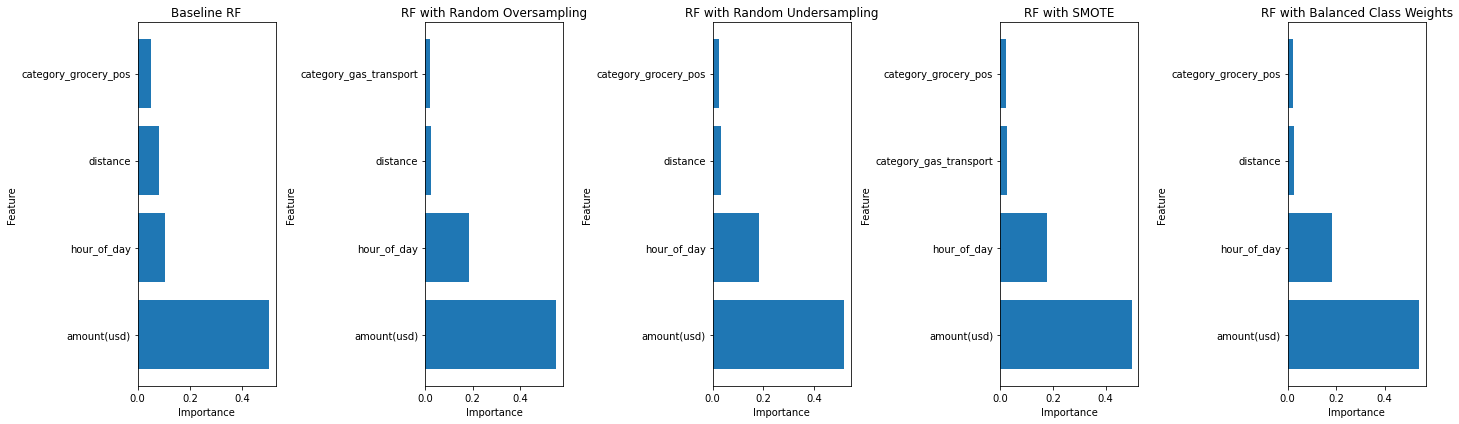

In [206]:
rf_model_with_oversampling = random_overs_pipeline.named_steps['randomforestclassifier']
rf_random_undersampling = random_unders_pipeline.named_steps['randomforestclassifier']
rf_smote = smote_pipeline.named_steps['randomforestclassifier']

# Plot feature importance for all models side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

# Plot for the baseline RF model
plot_feature_importance(axes[0], baseline_rf, X_train_final)
axes[0].set_title("Baseline RF")

# Plot for the RF with random oversampling model
plot_feature_importance(axes[1], rf_model_with_oversampling, X_train_final)
axes[1].set_title("RF with Random Oversampling")

# Plot for the RF with random undersampling model
plot_feature_importance(axes[2], rf_random_undersampling, X_train_final)
axes[2].set_title("RF with Random Undersampling")

# Plot for the RF with SMOTE model
plot_feature_importance(axes[3], rf_smote, X_train_final)
axes[3].set_title("RF with SMOTE")

# Plot for the RF with balanced class weights model
plot_feature_importance(axes[4], rfb, X_train_final)
axes[4].set_title("RF with Balanced Class Weights")

plt.tight_layout()
plt.show()


We can see the amount (usd) is an important factor across all models, and hour_of_day and distance are also quite common albeit to a smaller extent compared to amount (usd).

## Performance Comparison

In [208]:
predictions = pd.concat([rf_score, under2_rf_score, smote2_rf_score, over2_rf_score, balanced2_rf_score, balanced_rf_score, under_rf_score, smote_rf_score, over_rf_score], ignore_index=True, sort=False)
predictions.sort_values(by=['F1 Score'], ascending=False)

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
8,Random Oversampling,0.755440,0.937018,0.836489,0.709135,0.877587
7,SMOTE Oversampling,0.749223,0.917513,0.824872,0.688728,0.874435
5,Balanced Class Weights,0.711917,0.964888,0.819320,0.688421,0.855891
0,No Under/Oversampling,0.706736,0.963277,0.815302,0.682310,0.853297
2,SMOTE Oversampling using GridSearch,0.434197,0.978972,0.601579,0.428014,0.717074
4,Balanced Class Weights using GridSearch,0.434197,0.978972,0.601579,0.428014,0.717074
3,Random Oversampling using GridSearch,0.939896,0.197603,0.326553,0.186040,0.959955
6,Random Undersampling,0.964767,0.168415,0.286770,0.162665,0.969910
1,Random undersampling using GridSearch,0.949223,0.142060,0.247133,0.135111,0.959601


From the results above, we can see that random oversampling performed slightly better than the base model looking at the scores.

## Evaluate Model on Test Set

In [209]:
random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))
#cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [210]:
random_overs_pipeline.fit(X_over, y_over)

y_pred_best = random_overs_pipeline.predict(X_test_final)

In [211]:
cm = confusion_matrix(y_test, y_pred_best)

best_rf_Recall = recall_score(y_test, y_pred_best)
best_rf_Precision = precision_score(y_test, y_pred_best)
best_rf_f1 = f1_score(y_test, y_pred_best)
best_rf_accuracy = accuracy_score(y_test, y_pred_best)
best_roc = roc_auc_score(y_test, y_pred_best)
best_prauc = average_precision_score(y_test, y_pred_best)

print(cm)


[[184212     63]
 [   205    760]]


In [212]:
ndf = [(best_rf_Recall, best_rf_Precision, best_rf_f1, best_prauc, best_roc)]

best_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'PR AUC', 'ROC_AUC'])
best_rf_score.insert(0, 'Random Forest with', 'Random Oversampling (Best)')
best_rf_score

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,Random Oversampling (Best),0.787565,0.923451,0.850112,0.728384,0.893611
